## 필요한 라이브러리 불러오기

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV, cross_validate
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import math
import joblib
import warnings
import sys
sys.path.append('../../3. DeepD_데이터 및 모델세이브파일/python_model')

import model2
warnings.filterwarnings("ignore")

# 1. 데이터 불러오기

In [21]:
# 타겟 고객(10,086명) 주류 구매 데이터
df = pd.read_csv("../../3. DeepD_데이터 및 모델세이브파일/python_data/data.csv", dtype = {'cust': str, 'rct_no': str})
df['de_dt'] = pd.to_datetime(df['de_dt'], format = '%Y%m%d')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89219 entries, 0 to 89218
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    89219 non-null  int64         
 1   cust          89219 non-null  object        
 2   rct_no        89219 non-null  object        
 3   chnl_dv       89219 non-null  int64         
 4   cop_c         89219 non-null  object        
 5   br_c          89066 non-null  object        
 6   pd_c          89219 non-null  object        
 7   de_dt         89219 non-null  datetime64[ns]
 8   de_hr         89219 non-null  int64         
 9   buy_am        89219 non-null  float64       
 10  buy_ct        89219 non-null  int64         
 11  ma_fem_dv     89219 non-null  object        
 12  ages          89219 non-null  object        
 13  zon_hlv       89219 non-null  object        
 14  pd_nm         89219 non-null  object        
 15  clac_hlv_nm   89219 non-null  object

In [22]:
del df['Unnamed: 0']
df.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,ma_fem_dv,ages,zon_hlv,pd_nm,clac_hlv_nm,clac_mcls_nm
0,M879094374,A01000102788,1,A01,A010032,PD1349,2021-01-01,14,25000.0,1,여성,50대,Z10,와인세트,주류,주류세트
1,M879094374,A01000102788,1,A01,A010032,PD1349,2021-01-01,14,42000.0,2,여성,50대,Z10,와인세트,주류,주류세트
2,M879094374,A01000102788,1,A01,A010032,PD1349,2021-01-01,14,18000.0,1,여성,50대,Z10,와인세트,주류,주류세트
3,M879094374,A01000102788,1,A01,A010032,PD1349,2021-01-01,14,52000.0,2,여성,50대,Z10,와인세트,주류,주류세트
4,M879094374,A01000102788,1,A01,A010032,PD1349,2021-01-01,14,40000.0,2,여성,50대,Z10,와인세트,주류,주류세트


# 2. EDA

In [4]:
# 유저별 거래 종류 다양성
customer_unique_transaction_series = df.groupby('cust')['pd_nm'].nunique()
customer_unique_transaction_series.describe()

count    10086.000000
mean         2.856732
std          1.671659
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         12.000000
Name: pd_nm, dtype: float64

In [5]:
# 유저별 거래 빈도 탐색
customer_unique_transaction_series = df.groupby('cust')['rct_no'].nunique()
customer_unique_transaction_series.describe()

count    10086.000000
mean         5.420286
std          4.815170
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         39.000000
Name: rct_no, dtype: float64

In [6]:
# 유저별 거래 제휴사 탐색
customer_unique_transaction_series = df.groupby('cust')['cop_c'].nunique()
customer_unique_transaction_series.describe()

count    10086.000000
mean         1.351378
std          0.586133
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: cop_c, dtype: float64

In [7]:
#주류 거래 유통사 
df.groupby('cop_c')['rct_no'].nunique()

cop_c
A01     2827
A02    30771
A03    13978
A04     7072
A06       21
Name: rct_no, dtype: int64

In [8]:
# 가장 거래가 많은 상품 top 10 탐색
df.groupby('pd_nm')['rct_no'].nunique().sort_values(ascending=False)[:10]

pd_nm
국산맥주       19171
일반소주       15850
수입맥주       13379
막걸리         6319
레드와인        5728
화이트와인       1849
청주          1336
칵테일소주       1155
무알콜맥주       1135
과실주/담금주     1045
Name: rct_no, dtype: int64

In [9]:
#구매건수
df.groupby('pd_nm')['buy_ct'].sum().sort_values(ascending=False)[:10]

pd_nm
수입맥주       44376
국산맥주       37810
일반소주       31099
막걸리        11097
레드와인        9772
무알콜맥주       3024
화이트와인       2348
칵테일소주       2301
청주          2138
과실주/담금주     1808
Name: buy_ct, dtype: int64

# 3. 데이터 전처리

In [23]:
df['cop_pd'] = df['cop_c'] + df['pd_nm']
df['cop_pd'] = df.cop_pd.astype('category')
df.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,ma_fem_dv,ages,zon_hlv,pd_nm,clac_hlv_nm,clac_mcls_nm,cop_pd
0,M879094374,A01000102788,1,A01,A010032,PD1349,2021-01-01,14,25000.0,1,여성,50대,Z10,와인세트,주류,주류세트,A01와인세트
1,M879094374,A01000102788,1,A01,A010032,PD1349,2021-01-01,14,42000.0,2,여성,50대,Z10,와인세트,주류,주류세트,A01와인세트
2,M879094374,A01000102788,1,A01,A010032,PD1349,2021-01-01,14,18000.0,1,여성,50대,Z10,와인세트,주류,주류세트,A01와인세트
3,M879094374,A01000102788,1,A01,A010032,PD1349,2021-01-01,14,52000.0,2,여성,50대,Z10,와인세트,주류,주류세트,A01와인세트
4,M879094374,A01000102788,1,A01,A010032,PD1349,2021-01-01,14,40000.0,2,여성,50대,Z10,와인세트,주류,주류세트,A01와인세트


In [24]:
# 2021년 10월을 기준으로 하여 기준 이전과 이후로 데이터를 분리한다.
df_year_round = df[df['de_dt'] < datetime.datetime(2021, 10, 1)]
df_year_end = df[df['de_dt'] > datetime.datetime(2021, 10, 1)]
print(df_year_round.shape)
print(df_year_end.shape)

(69591, 17)
(19370, 17)


In [25]:
# Rating 데이터를 생성하기 위한 탐색: 유저-상품간 구매 횟수를 탐색한다.
uir_df = df_year_round.groupby(['cust','cop_pd'])['rct_no'].nunique().reset_index()
uir_df


,cust,cop_pd,rct_no
0,M000034966,A01과실주/담금주,0
1,M000034966,A01국산맥주,0
2,M000034966,A01기타양주,0
3,M000034966,A01기타전통주,0
4,M000034966,A01레드와인,0
...,...,...,...
816961,M999962961,A04청주,0
816962,M999962961,A04화이트와인,0
816963,M999962961,A06국산맥주,0
816964,M999962961,A06막걸리,0


In [26]:
#rct_no이 0인 데이터는 삭제
A = uir_df[uir_df['rct_no'] == 0].index
uir_df.drop(A,axis='index',inplace=True)
uir_df

,cust,cop_pd,rct_no
20,M000034966,A02국산맥주,1
63,M000034966,A04국산맥주,1
101,M000136117,A02국산맥주,1
225,M000201112,A04국산맥주,1
236,M000201112,A04일반소주,1
...,...,...,...
816927,M999962961,A03국산맥주,1
816931,M999962961,A03레드와인,2
816933,M999962961,A03막걸리,1
816935,M999962961,A03수입맥주,2


<AxesSubplot:>

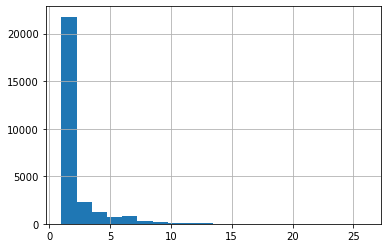

In [27]:
# Rating(InvoiceNo) 피처의 분포를 탐색한다.
uir_df['rct_no'].hist(bins=20, grid=True)

<AxesSubplot:>

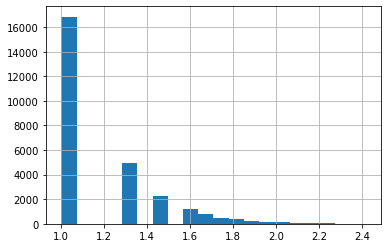

In [28]:
# Rating(InvoiceNo) 피처를 log normalization 해준 뒤, 다시 분포를 탐색한다.
uir_df['rct_no'].apply(lambda x: np.log10(x)+1).hist(bins=20, grid=True)

<AxesSubplot:>

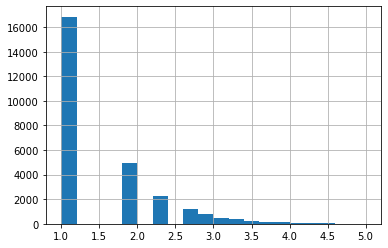

In [29]:
# 1~5 사이의 점수로 변환한다.
uir_df['Rating'] = uir_df['rct_no'].apply(lambda x: np.log10(x)+1)
uir_df['Rating'] = ((uir_df['Rating'] - uir_df['Rating'].min()) / 
                    (uir_df['Rating'].max() - uir_df['Rating'].min()) *4) +1
uir_df['Rating'].hist(bins=20, grid=True)

In [30]:
# 모델 학습을 위한 데이터셋을 생성
uir_df = uir_df[['cust', 'cop_pd', 'Rating']]
uir_df

,cust,cop_pd,Rating
20,M000034966,A02국산맥주,1.000000
63,M000034966,A04국산맥주,1.000000
101,M000136117,A02국산맥주,1.000000
225,M000201112,A04국산맥주,1.000000
236,M000201112,A04일반소주,1.000000
...,...,...,...
816927,M999962961,A03국산맥주,1.000000
816931,M999962961,A03레드와인,1.850984
816933,M999962961,A03막걸리,1.000000
816935,M999962961,A03수입맥주,1.850984


In [72]:
# data save
#joblib.dump(uir_df,'../../3. DeepD_데이터 및 모델세이브파일/python_data/유통사주류추천에쓰이는데이터.pkl')

In [83]:
#file -> model load
#uir_df= joblib.load('../../3. DeepD_데이터 및 모델세이브파일/python_data/유통사주류추천에쓰이는데이터.pkl')

# 4.모형적합

In [31]:
# 학습 데이터를 생성. 성능검정을 위해 학습 데이터와 테스트 데이터를 8:2로 분할
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(uir_df[['cust', 'cop_pd', 'Rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

## 4-1. 특이값 분해모델

In [103]:
# SVD 모델을 학습
train_start = time.time()
model = SVD()
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

# 테스트 데이터의 RMSE를 출력하여 모델의 성능을 평가 한다
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

training time of model: 0.96 seconds
RMSE of test dataset in SVD model:
RMSE: 0.7365


0.7365133074183151

In [20]:

param_grid = {'n_factors': [5,10,20], 'reg_all': [0.01, 0.1, 0.5]} 
gs = GridSearchCV(algo_class=SVD, measures=['RMSE'], param_grid=param_grid) 
gs.fit(data) 
print('\n###################') 
print('Best Score :', gs.best_score['rmse']) 
print('Best Parameters :', gs.best_params['rmse']) 
print('#####################')


###################
Best Score : 0.7484872317547564
Best Parameters : {'n_factors': 10, 'reg_all': 0.1}
#####################


In [21]:
best_params = gs.best_params['rmse']

In [22]:
#model = SVD(n_factors=best_params['n_factors'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'], biased=False)
model = SVD(n_factors=best_params['n_factors'], reg_all=best_params['reg_all'], biased=True)

### SVD 학습
model.fit(train_data)

### 최종으로 RMSE 측정
predictions = model.test(test_data)
accuracy.rmse(predictions)

RMSE: 0.7453


0.7452637787902306

In [78]:
# model save
#joblib.dump(model,'../../3. DeepD_데이터 및 모델세이브파일/python_model/특이값분해모델.pkl')

['특이값분해모델.pkl']

In [80]:
#file -> model load
#model= joblib.load('../../3. DeepD_데이터 및 모델세이브파일/python_model/특이값분해모델.pkl')

In [65]:
# 이전에 구매하지 않았던 상품을 예측의 대상으로 선정한다.
test_data = train_data.build_anti_testset()
target_user_predictions = model.test(test_data)

In [66]:
# 구매 예측 결과를 딕셔너리 형태로 변환한다.
new_order_prediction_dict = {}
for customer_id, stock_code, _, predicted_rating, _ in target_user_predictions:
    if customer_id in new_order_prediction_dict:
        if stock_code in new_order_prediction_dict[customer_id]:
            pass
        else:
            new_order_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        new_order_prediction_dict[customer_id] = {}
        new_order_prediction_dict[customer_id][stock_code] = predicted_rating
                
print(str(new_order_prediction_dict)[:300] + "...")

{'M148973899': {'A04막걸리': 1.4055145662619704, 'A04일반소주': 1.5340094195358371, 'A02국산맥주': 1.6837333745156031, 'A02레드와인': 1.4762332984619955, 'A01일반소주': 1.36901177539136, 'A02화이트와인': 1.397058472245291, 'A04국산맥주': 1.577327780626568, 'A02막걸리': 1.5847559208293245, 'A01수입맥주': 1.3403838367088547, 'A02수입맥주':...


In [67]:
# 이전에 구매했었던 상품을 예측의 대상으로 선정한다.
test_data = train_data.build_testset()
target_user_predictions = model.test(test_data)

In [68]:
# 구매 예측 결과를 딕셔너리 형태로 변환한다.
reorder_prediction_dict = {}
for customer_id, stock_code, _, predicted_rating, _ in target_user_predictions:
    if customer_id in reorder_prediction_dict:
        if stock_code in reorder_prediction_dict[customer_id]:
            pass
        else:
            reorder_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        reorder_prediction_dict[customer_id] = {}
        reorder_prediction_dict[customer_id][stock_code] = predicted_rating
        
print(str(reorder_prediction_dict)[:300] + "...")

{'M148973899': {'A01기타전통주': 1.2982043221907065, 'A02일반소주': 1.7199088821173454, 'A01레드와인': 1.559884890656151, 'A01위스키': 1.3237029951979136}, 'M377967649': {'A04막걸리': 1.223877100008274, 'A04국산맥주': 1.4080552411999017, 'A03수입맥주': 1.5008849704145601, 'A03국산맥주': 1.6292095824900301}, 'M634090523': {'A04일반소...


In [69]:
# 두 딕셔너리를 하나로 통합한다.
total_prediction_dict = {}

# new_order_prediction_dict 정보를 새로운 딕셔너리에 저장한다.
for customer_id in new_order_prediction_dict:
    if customer_id not in total_prediction_dict:
        total_prediction_dict[customer_id] = {}
    for stock_code, predicted_rating in new_order_prediction_dict[customer_id].items():
        if stock_code not in total_prediction_dict[customer_id]:
            total_prediction_dict[customer_id][stock_code] = predicted_rating
            
# reorder_prediction_dict 정보를 새로운 딕셔너리에 저장한다.
for customer_id in reorder_prediction_dict:
    if customer_id not in total_prediction_dict:
        total_prediction_dict[customer_id] = {}
    for stock_code, predicted_rating in reorder_prediction_dict[customer_id].items():
        if stock_code not in total_prediction_dict[customer_id]:
            total_prediction_dict[customer_id][stock_code] = predicted_rating
            
print(str(total_prediction_dict)[:300] + "...")

{'M148973899': {'A04막걸리': 1.4055145662619704, 'A04일반소주': 1.5340094195358371, 'A02국산맥주': 1.6837333745156031, 'A02레드와인': 1.4762332984619955, 'A01일반소주': 1.36901177539136, 'A02화이트와인': 1.397058472245291, 'A04국산맥주': 1.577327780626568, 'A02막걸리': 1.5847559208293245, 'A01수입맥주': 1.3403838367088547, 'A02수입맥주':...


In [70]:
# 10월 이후의 데이터를 테스트 데이터셋으로 사용하기 위한 데이터 프레임을 생성한다.
simulation_test_df = df_year_end.groupby('cust')['cop_pd'].apply(set).reset_index()
simulation_test_df.columns = ['CustomerID', 'RealOrdered']
simulation_test_df.head()

,CustomerID,RealOrdered
0,M000871427,"{A02수입맥주, A02국산맥주}"
1,M001353506,{A04국산맥주}
2,M001437402,{A02화이트와인}
3,M001639664,{A02국산맥주}
4,M001640580,{A03국산맥주}


In [71]:
# 이 데이터프레임에 상품 추천 시뮬레이션 결과를 추가하기 위한 함수를 정의한다.
def add_predicted_stock_set(customer_id, prediction_dict):
    if customer_id in prediction_dict:
        predicted_stock_dict = prediction_dict[customer_id]
        # 예측된 상품의 Rating이 높은 순으로 정렬한다.
        sorted_stocks = sorted(predicted_stock_dict, key=lambda x : predicted_stock_dict[x], reverse=True)
        return sorted_stocks
    else:
        return None

# 상품 추천 시뮬레이션 결과를 추가하다.
simulation_test_df['PredictedOrder(New)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, new_order_prediction_dict))
simulation_test_df['PredictedOrder(Reorder)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, reorder_prediction_dict))
simulation_test_df['PredictedOrder(Total)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, total_prediction_dict))
simulation_test_df

,CustomerID,RealOrdered,PredictedOrder(New),PredictedOrder(Reorder),PredictedOrder(Total)
0,M000871427,"{A02수입맥주, A02국산맥주}","[A03국산맥주, A03일반소주, A03수입맥주, A04와인세트, A03막걸리, A...","[A02일반소주, A02국산맥주]","[A03국산맥주, A03일반소주, A02일반소주, A02국산맥주, A03수입맥주, ..."
1,M001353506,{A04국산맥주},"[A03국산맥주, A03일반소주, A02일반소주, A02국산맥주, A03수입맥주, ...","[A04일반소주, A04화이트와인]","[A03국산맥주, A03일반소주, A02일반소주, A02국산맥주, A03수입맥주, ..."
2,M001437402,{A02화이트와인},"[A03국산맥주, A02일반소주, A02국산맥주, A03막걸리, A01리큐르, A0...","[A03일반소주, A03수입맥주, A02레드와인]","[A03국산맥주, A03일반소주, A02일반소주, A02국산맥주, A03수입맥주, ..."
3,M001639664,{A02국산맥주},"[A03국산맥주, A03일반소주, A02일반소주, A03수입맥주, A06국산맥주, ...",[A02국산맥주],"[A03국산맥주, A03일반소주, A02일반소주, A02국산맥주, A03수입맥주, ..."
4,M001640580,{A03국산맥주},"[A03일반소주, A02일반소주, A03수입맥주, A02국산맥주, A01리큐르, A...",[A03국산맥주],"[A03국산맥주, A03일반소주, A02일반소주, A03수입맥주, A02국산맥주, ..."
...,...,...,...,...,...
4926,M998980052,{A02수입맥주},None,None,None
4927,M998998777,"{A03국산맥주, A03일반소주}","[A03국산맥주, A02일반소주, A02국산맥주, A03수입맥주, A04와인세트, ...",[A03일반소주],"[A03국산맥주, A03일반소주, A02일반소주, A02국산맥주, A03수입맥주, ..."
4928,M999181273,"{A04리큐르, A04수입맥주}","[A03국산맥주, A03일반소주, A02일반소주, A03수입맥주, A02국산맥주, ...",[A04국산맥주],"[A03국산맥주, A03일반소주, A02일반소주, A03수입맥주, A02국산맥주, ..."
4929,M999213998,{A02수입맥주},"[A03국산맥주, A03일반소주, A02일반소주, A03수입맥주, A02국산맥주, ...",[A02수입맥주],"[A03국산맥주, A03일반소주, A02일반소주, A03수입맥주, A02국산맥주, ..."


In [72]:
# 구매 예측의 상위 k개의 recall(재현율)을 평가 기준으로 정의합니다.
def calculate_recall(real_order, predicted_order, k):
    # 만약 추천 대상 상품이 없다면, 11월 이후에 상품을 처음 구매하는 유저입니다.
    if predicted_order is None:
        return None
    
    # SVD 모델에서 현재 유저의 Rating이 높은 상위 k개의 상품을 "구매 할 것으로 예측"합니다.
    predicted = predicted_order[:k]
    true_positive = 0
    for stock_code in predicted:
        if stock_code in real_order:
            true_positive += 1
    
    # 예측한 상품 중, 실제로 유저가 구매한 상품의 비율(recall)을 계산합니다.
    recall = true_positive / len(predicted)
    return recall

In [73]:
# 시뮬레이션 대상 유저에게 상품을 추천해준 결과를 평가합니다.
simulation_test_df['top_k_recall(Reorder)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(Reorder)'], 
                                                                                 3), axis=1)
simulation_test_df['top_k_recall(New)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(New)'], 
                                                                                 3), axis=1)
simulation_test_df['top_k_recall(Total)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(Total)'], 
                                                                                 3), axis=1)

In [74]:
# 평가 결과를 점수 기준으로 살펴본다.
simulation_test_df['top_k_recall(Reorder)'].value_counts()

0.000000    1492
1.000000    1018
0.333333     983
0.500000     649
0.666667     533
Name: top_k_recall(Reorder), dtype: int64

In [33]:
# 평가 결과를 점수 기준으로 살펴보자
simulation_test_df['top_k_recall(New)'].value_counts()

0.000000    3795
0.333333     788
0.666667      84
1.000000       8
Name: top_k_recall(New), dtype: int64

In [34]:
# 평가 결과를 점수 기준으로 살펴본다.
simulation_test_df['top_k_recall(Total)'].value_counts()

0.000000    2936
0.333333    1429
0.666667     272
1.000000      38
Name: top_k_recall(Total), dtype: int64

3개의 시뮬레이션의 평가 결과, 그 중 재구매할만한 상품을 추천해주는 것이 가장 좋은 시뮬레이션인 것으로 평가됨.

In [35]:
# 추천 시뮬레이션 결과를 살펴본다.
k = 5
result_df = simulation_test_df[simulation_test_df['PredictedOrder(Reorder)'].notnull()]
result_df['PredictedOrder(Reorder)'] = result_df['PredictedOrder(Reorder)'].\
                                        apply(lambda x: x[:k])
result_df = result_df[['CustomerID', 'RealOrdered', 'PredictedOrder(Reorder)', 'top_k_recall(Reorder)']]

result_df.columns = [['구매자ID', '실제주문', '5개추천결과', 'Top5추천_주문재현도']]

result_df

,구매자ID,실제주문,5개추천결과,Top5추천_주문재현도
0,M000871427,"{A02수입맥주, A02국산맥주}","[A02일반소주, A02국산맥주]",0.500000
1,M001353506,{A04국산맥주},"[A04일반소주, A04화이트와인]",0.000000
2,M001437402,{A02화이트와인},"[A03일반소주, A03수입맥주, A02레드와인]",0.000000
3,M001639664,{A02국산맥주},[A02국산맥주],1.000000
4,M001640580,{A03국산맥주},[A03국산맥주],1.000000
...,...,...,...,...
4925,M998905712,"{A04국산맥주, A02수입맥주, A04수입맥주, A02국산맥주}","[A02수입맥주, A04수입맥주]",1.000000
4927,M998998777,"{A03국산맥주, A03일반소주}",[A03일반소주],1.000000
4928,M999181273,"{A04리큐르, A04수입맥주}",[A04국산맥주],0.000000
4929,M999213998,{A02수입맥주},[A02수입맥주],1.000000


In [36]:
#result_df.to_csv('../../3. DeepD_데이터 및 모델세이브파일/python_data/result_first.csv')

## 4-2. 아이템기반협업필터링

In [32]:
product_user_rating=uir_df.pivot_table('Rating', index='cop_pd', columns='cust')
user_product_rating=uir_df.pivot_table('Rating', index='cust',columns='cop_pd')
product_user_rating.head()

cust,M000034966,M000136117,M000201112,M000494848,M000705571,M000871427,M000986912,M001332751,M001353506,M001403108,...,M998980052,M998998777,M999105944,M999153368,M999181273,M999213998,M999238704,M999770689,M999849895,M999962961
cop_pd,,,,,,,,,,,,,,,,,,,,,
A01과실주/담금주,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A01국산맥주,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A01기타양주,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A01기타전통주,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A01레드와인,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
#결측치를 0으로
product_user_rating.fillna(0, inplace=True)

In [34]:
# 아이템 유사도 행렬
item_sim = cosine_similarity(product_user_rating, product_user_rating)

# 데이터 프레임 형태로 저장
item_sim_df = pd.DataFrame(item_sim, index=product_user_rating.index, columns=product_user_rating.index)

# item_sim_df.shape: 9719 x 9719
item_sim_df.iloc[:4,:4]

cop_pd,A01과실주/담금주,A01국산맥주,A01기타양주,A01기타전통주
cop_pd,,,,
A01과실주/담금주,1.0,0.000000,0.000000,0.000000
A01국산맥주,0.0,1.000000,0.026476,0.120182
A01기타양주,0.0,0.026476,1.000000,0.035173
A01기타전통주,0.0,0.120182,0.035173,1.000000


In [77]:
# data save
#joblib.dump(item_sim_df,'../../3. DeepD_데이터 및 모델세이브파일/python_data/아이템기반협업필터링모델input데이터2.pkl')

In [124]:
#file -> data load
#item_sim_df= joblib.load('../../3. DeepD_데이터 및 모델세이브파일/python_data/아이템기반협업필터링모델input데이터2.pkl')

In [28]:
item_sim_df["A01레드와인"].sort_values(ascending=False)[1:6]

cop_pd
A01기타양주     0.255398
A01와인세트     0.166960
A01기타전통주    0.124940
A01화이트와인    0.114251
A01일반소주     0.113170
Name: A01레드와인, dtype: float64

In [29]:
# 인수로 사용자-아이템 평점 행렬(NaN은 현재 0으로 대체), 아이템 유사도 행렬 사용
def predict_rating(ratings_arr, item_sim_arr):
    # ratings_arr: u x i, item_sim_arr: i x i
    sum_sr = ratings_arr @ item_sim_arr
    sum_s_abs = np.array( [ np.abs(item_sim_arr).sum(axis=1) ] )
    
    ratings_pred =  sum_sr / sum_s_abs
    
    return ratings_pred

In [30]:
product_user_rating_T=product_user_rating.T

In [41]:
# data save
#joblib.dump(product_user_rating_T,'../../3. DeepD_데이터 및 모델세이브파일/python_data/아이템기반협업필터링모델input데이터1.pkl')

In [42]:
#file -> data load
#product_user_rating_T= joblib.load('../../3. DeepD_데이터 및 모델세이브파일/python_data/아이템기반협업필터링모델input데이터1.pkl')

In [31]:
# 사용자별 예측 평점
ratings_pred = predict_rating(product_user_rating_T.values , item_sim_df.values)

ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index= product_user_rating_T.index,
                                   columns = product_user_rating_T.columns)
ratings_pred_matrix.head(3)

cop_pd,A01과실주/담금주,A01국산맥주,A01기타양주,A01기타전통주,A01레드와인,A01리큐르,A01막걸리,A01무알콜맥주,A01브랜디/꼬냑,A01수입맥주,...,A04스파클링와인,A04와인세트,A04위스키,A04일반소주,A04전통주세트,A04청주,A04화이트와인,A06국산맥주,A06막걸리,A06수입맥주
cust,,,,,,,,,,,,,,,,,,,,,
M000034966,0.028963,0.030736,0.011759,0.009885,0.034458,0.005956,0.002589,0.022049,0.002433,0.011813,...,0.012255,0.0,0.037149,0.141037,0.046714,0.059493,0.058385,0.008999,0.007383,0.012824
M000136117,0.000000,0.013345,0.002382,0.004929,0.016898,0.002335,0.002589,0.012695,0.002433,0.005722,...,0.006396,0.0,0.002292,0.016027,0.007395,0.009951,0.003860,0.002576,0.007383,0.004321
M000201112,0.028963,0.022146,0.013286,0.006778,0.026140,0.007925,0.000000,0.020471,0.000000,0.009678,...,0.005860,0.0,0.073926,0.373920,0.071335,0.116813,0.086929,0.006423,0.000000,0.008503


In [32]:
# 성능 평가는 MSE를 사용
def get_mse(pred, actual):
    # rating이 있는 실제 제품만 추출 (1차원 배열로 변환)
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    
    return mean_squared_error(pred, actual)

In [33]:
MSE = get_mse(ratings_pred, product_user_rating_T.values)
MSE1 = math.sqrt(MSE)
print(f'아이템 기반 모든 인접 이웃 RMSE: {MSE1:.4f}')

아이템 기반 모든 인접 이웃 RMSE: 1.1438


In [34]:
def predict_rating_topsim(ratings_arr, item_sim_arr, N=20):
    # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
    pred = np.zeros(ratings_arr.shape)

    # 사용자-아이템 평점 행렬의 열 크기(아이템 수)만큼 반복 (row: 사용자, col: 아이템)
    for col in range(ratings_arr.shape[1]):
                
        # 특정 아이템의 유사도 행렬 오름차순 정렬시 index .. (1)
        temp = np.argsort(item_sim_arr[:, col]) 
        
        # (1)의 index를 역순으로 나열시 상위 N개의 index = 특정 아이템의 유사도 상위 N개 아이템 index .. (2)
        top_n_items = [ temp[:-1-N:-1] ]
        
        # 개인화된 예측 평점을 계산: 반복당 특정 아이템의 예측 평점(사용자 전체)
        for row in range(ratings_arr.shape[0]):
            
            # (2)의 유사도 행렬
            item_sim_arr_topN = item_sim_arr[col, :][top_n_items].T # N x 1
            
            # (2)의 실제 평점 행렬
            ratings_arr_topN = ratings_arr[row, :][top_n_items]     # 1 x N
            
            # 예측 평점
            pred[row, col] = ratings_arr_topN @ item_sim_arr_topN
            pred[row, col] /= np.sum( np.abs(item_sim_arr_topN) )
            
    return pred

In [37]:
# model save
joblib.dump(predict_rating_topsim,'../../3. DeepD_데이터 및 모델세이브파일/python_model/아이템기반협업필터링모델.pkl')

['../../3. DeepD_데이터 및 모델세이브파일/python_model/아이템기반협업필터링모델.pkl']

In [39]:
# 사용자별 예측 평점
ratings_pred = predict_rating_topsim(product_user_rating_T.values , item_sim_df.values, N=5)

In [40]:
# 성능 평가
MSE2 = get_mse(ratings_pred, product_user_rating_T.values )
MSE3 = math.sqrt(MSE2)
print(f'아이템 기반 인접 TOP-5 이웃 RMSE: {MSE3:.4f}')

아이템 기반 인접 TOP-5 이웃 RMSE: 0.6909


In [41]:
# 예측 평점 데이터 프레임
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index= product_user_rating_T.index,
                                   columns = product_user_rating_T.columns)

In [38]:
# 이 데이터프레임에 상품 추천 시뮬레이션 결과를 추가하기 위한 함수를 정의한다.
def add_predicted_stock_set(customer_id, prediction_dict):
    if customer_id in prediction_dict.index:
        predicted_stock_dict = prediction_dict.loc[[customer_id]]
        predicted_stock_dict = predicted_stock_dict.T
        # 예측된 상품의 Rating이 높은 순으로 정렬한다.
        sorted_stocks = predicted_stock_dict.sort_values ( customer_id ,ascending=False).index[:5].values
        return sorted_stocks
    else:
        return None

In [43]:
# 10월 이후의 데이터를 테스트 데이터셋으로 사용하기 위한 데이터 프레임을 생성한다.
simulation_test_df = df_year_end.groupby('cust')['cop_pd'].apply(set).reset_index()
simulation_test_df.columns = ['CustomerID', 'RealOrdered']
simulation_test_df.head()

,CustomerID,RealOrdered
0,M000871427,"{A02국산맥주, A02수입맥주}"
1,M001353506,{A04국산맥주}
2,M001437402,{A02화이트와인}
3,M001639664,{A02국산맥주}
4,M001640580,{A03국산맥주}


In [50]:
# 상품 추천 시뮬레이션 결과를 추가하다.
simulation_test_df['PredictedOrder(New)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, ratings_pred_matrix))

simulation_test_df

,CustomerID,RealOrdered,PredictedOrder(New)
0,M000871427,"{A02수입맥주, A02국산맥주}","['A02국산맥주', 'A02일반소주', 'A02수입맥주', 'A02막걸리', 'A..."
1,M001353506,{A04국산맥주},"['A04일반소주', 'A04국산맥주', 'A04화이트와인', 'A04수입맥주', ..."
2,M001437402,{A02화이트와인},"['A03레드와인', 'A03일반소주', 'A03수입맥주', 'A03국산맥주', '..."
3,M001639664,{A02국산맥주},"['A02국산맥주', 'A02수입맥주', 'A02일반소주', 'A02막걸리', 'A..."
4,M001640580,{A03국산맥주},"['A03국산맥주', 'A03일반소주', 'A03수입맥주', 'A03막걸리', 'A..."
...,...,...,...
4926,M998980052,{A02수입맥주},"['A02수입맥주', 'A02국산맥주', 'A02일반소주', 'A02막걸리', 'A..."
4927,M998998777,"{A03국산맥주, A03일반소주}","['A03국산맥주', 'A03일반소주', 'A03수입맥주', 'A03막걸리', 'A..."
4928,M999181273,"{A04리큐르, A04수입맥주}","['A04국산맥주', 'A04일반소주', 'A04수입맥주', 'A04막걸리', 'A..."
4929,M999213998,{A02수입맥주},"['A02수입맥주', 'A02국산맥주', 'A02일반소주', 'A02막걸리', 'A..."


In [51]:
#재현율계산
simulation_test_df['top_k_recall(New)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(New)'], 
                                                                                 5), axis=1)

In [52]:
# 평가 결과를 점수 기준으로 살펴보자
simulation_test_df['top_k_recall(New)'].value_counts()

0.2    2172
0.4    1298
0.0     870
0.6     453
0.8     129
1.0       9
Name: top_k_recall(New), dtype: int64

In [53]:
simulation_test_df.to_csv("result_second.csv")

# 5. 타겟의 최종 추천 상품 도출

In [35]:
simulation= df_year_round.groupby('cust')['cop_pd'].apply(set).reset_index()
simulation.columns = ['CustomerID', 'RealOrdered']
simulation.head()

,CustomerID,RealOrdered
0,M000034966,"{A04국산맥주, A02국산맥주}"
1,M000136117,{A02국산맥주}
2,M000201112,"{A04국산맥주, A04일반소주}"
3,M000494848,{A02무알콜맥주}
4,M000705571,{A02막걸리}


In [36]:
# model save
#joblib.dump(simulation,'../../3. DeepD_데이터 및 모델세이브파일/python_data/타겟고객이실제산물건.pkl')

['../../3. DeepD_데이터 및 모델세이브파일/python_data/타겟고객이실제산물건.pkl']

In [3]:
#file -> data load
product_user_rating_T= joblib.load('../../3. DeepD_데이터 및 모델세이브파일/python_data/아이템기반협업필터링모델input데이터1.pkl')
item_sim_df=joblib.load('../../3. DeepD_데이터 및 모델세이브파일/python_data/아이템기반협업필터링모델input데이터2.pkl')

In [4]:
ratings_pred = model2.predict_rating_topsim(product_user_rating_T.values , item_sim_df.values, N=5)

In [6]:
# 예측 평점 데이터 프레임
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index= product_user_rating_T.index,
                                   columns = product_user_rating_T.columns)

In [7]:
ratings_pred_matrix

cop_pd,A01과실주/담금주,A01국산맥주,A01기타양주,A01기타전통주,A01레드와인,A01리큐르,A01막걸리,A01무알콜맥주,A01브랜디/꼬냑,A01수입맥주,...,A04스파클링와인,A04와인세트,A04위스키,A04일반소주,A04전통주세트,A04청주,A04화이트와인,A06국산맥주,A06막걸리,A06수입맥주
cust,,,,,,,,,,,,,,,,,,,,,
M000034966,0.028963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.048380,0.224656,0.039612,0.066558,0.077838,0.0,0.000000,0.008634
M000136117,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
M000201112,0.028963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.102608,0.671977,0.071866,0.156935,0.077838,0.0,0.000000,0.008634
M000494848,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
M000705571,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M999213998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.018524,0.000000
M999238704,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
M999770689,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.014680,0.027291


In [8]:
joblib.dump(ratings_pred_matrix,'../../3. DeepD_데이터 및 모델세이브파일/python_data/아이템기반협업필터링모델output.pkl')

['../../3. DeepD_데이터 및 모델세이브파일/python_data/아이템기반협업필터링모델output.pkl']

In [39]:
# 상품 추천 시뮬레이션 결과 추가
simulation['PredictedOrder'] = simulation['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, ratings_pred_matrix))

del simulation['RealOrdered']
simulation.head() 

,CustomerID,PredictedOrder
0,M000034966,"['A04국산맥주', 'A02국산맥주', 'A02일반소주', 'A04일반소주', '..."
1,M000136117,"['A02국산맥주', 'A02일반소주', 'A02수입맥주', 'A02막걸리', 'A..."
2,M000201112,"['A04일반소주', 'A04국산맥주', 'A04수입맥주', 'A04막걸리', 'A..."
3,M000494848,"['A02무알콜맥주', 'A01과실주/담금주', 'A03과실주/담금주', 'A03청..."
4,M000705571,"['A02막걸리', 'A02수입맥주', 'A02국산맥주', 'A02일반소주', 'A..."


In [50]:
simulation

,CustomerID,PredictedOrder
0,M000034966,"['A04국산맥주', 'A02국산맥주', 'A02일반소주', 'A04일반소주', '..."
1,M000136117,"['A02국산맥주', 'A02일반소주', 'A02수입맥주', 'A02막걸리', 'A..."
2,M000201112,"['A04일반소주', 'A04국산맥주', 'A04수입맥주', 'A04막걸리', 'A..."
3,M000494848,"['A02무알콜맥주', 'A01과실주/담금주', 'A03과실주/담금주', 'A03청..."
4,M000705571,"['A02막걸리', 'A02수입맥주', 'A02국산맥주', 'A02일반소주', 'A..."
...,...,...
10081,M999213998,"['A02수입맥주', 'A02국산맥주', 'A02일반소주', 'A02막걸리', 'A..."
10082,M999238704,"['A02화이트와인', 'A03국산맥주', 'A03일반소주', 'A03수입맥주', ..."
10083,M999770689,"['A02화이트와인', 'A02스파클링와인', 'A02레드와인', 'A02위스키',..."
10084,M999849895,"['A02일반소주', 'A02국산맥주', 'A02수입맥주', 'A02막걸리', 'A..."


In [51]:
simulation.to_csv("result_final(타겟고객최종구매주류예측).csv")